# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [161]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd

import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors

import torch
import torch.nn.functional as F
import botorch
import gpytorch

from src.selfies import SelfiesEncoder
from src.vae import MolecularVAE
from src.train import train_vae

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

# Preprocessing

Download raw dataset:

In [7]:
dataset_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"

raw_df = pd.read_csv(dataset_url)
raw_df.to_csv(os.path.join("data", "qm9_raw.csv"), index=False)

Add selfies encoding to raw data:

In [183]:
def compute_logp(smile: str) -> float:
    mol = Chem.MolFromSmiles(smile)
    return Descriptors.MolLogP(mol)

In [6]:
df = pd.read_csv(os.path.join("data", "qm9_raw.csv"))

df["selfies"] = [sf.encoder(x, strict=False) for x in df.smiles]
df["logp"] = [compute_logp(s) for s in df.smiles]
df = df[["mol_id", "smiles", "selfies", "mu", "alpha", "homo", "lumo", "gap", "r2", "logp"]]

df.to_csv(os.path.join("data", "qm9_processed.csv"), index=False)

Generate one-hot enocding for selfies strings:

In [35]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))
df.head()

,mol_id,smiles,selfies,mu,alpha,homo,lumo,gap,r2,logp
0,gdb_1,C,[C],0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.63610
1,gdb_2,N,[N],1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.16200
2,gdb_3,O,[O],1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,-0.82470
3,gdb_4,C#C,[C][#C],0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.24940
4,gdb_5,C#N,[C][#N],2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.13978


In [36]:
selfies = df.selfies
selfies_encoder = SelfiesEncoder.build(selfies)

In [9]:
one_hots = []
for s in tqdm(selfies):
    one_hots.append(selfies_encoder.encode_one_hot(s))
one_hots = torch.tensor(one_hots)
torch.save(one_hots, os.path.join(data_path, "qm9_encodings.pt"))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 133885/133885 [00:03<00:00, 34270.27it/s]


NameError: name 'data_path' is not defined

# VAE

## Training

In [486]:
torch.manual_seed(42)
device = device = 'cuda' if torch.cuda.is_available() else 'cpu'

x = torch.load(os.path.join("data", "qm9_encodings.pt"))
x = x.float().to(device)
full_dataset =  torch.utils.data.TensorDataset(x)

test_frac = 0.1
test_size = int(test_frac * len(x))
train_size = len(x) - test_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [487]:
batch_size = 250

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [488]:
latent_size = 35
model = MolecularVAE(latent_size=latent_size)
model.to(device)

print(f"# Parameters = {model.n_parameters()}")
model

# Parameters = 3891765


MolecularVAE(
  (encoder_conv): Sequential(
    (0): Conv1d(29, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(9, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(9, 10, kernel_size=(10,), stride=(1,), padding=(2,))
    (5): ReLU()
  )
  (encoder_linear): Sequential(
    (0): Linear(in_features=80, out_features=400, bias=True)
    (1): SELU()
  )
  (encoder_mean): Linear(in_features=400, out_features=35, bias=True)
  (encoder_logvar): Linear(in_features=400, out_features=35, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=35, out_features=35, bias=True)
    (1): SELU()
  )
  (decoder_gru): GRU(35, 500, num_layers=3, batch_first=True)
  (decoder_output): Linear(in_features=500, out_features=29, bias=True)
)

In [489]:
learning_rate = 2e-3
weight_decay = 1e-5

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay ,
)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[20, 40, 60, 80, 100, 150], 
    gamma=0.5
)

In [ ]:
n_epochs = 150

tracker = train_vae(
    model, 
    optimizer, 
    scheduler,
    train_loader, 
    test_loader,
    n_epochs=n_epochs,
    print_every=1
)

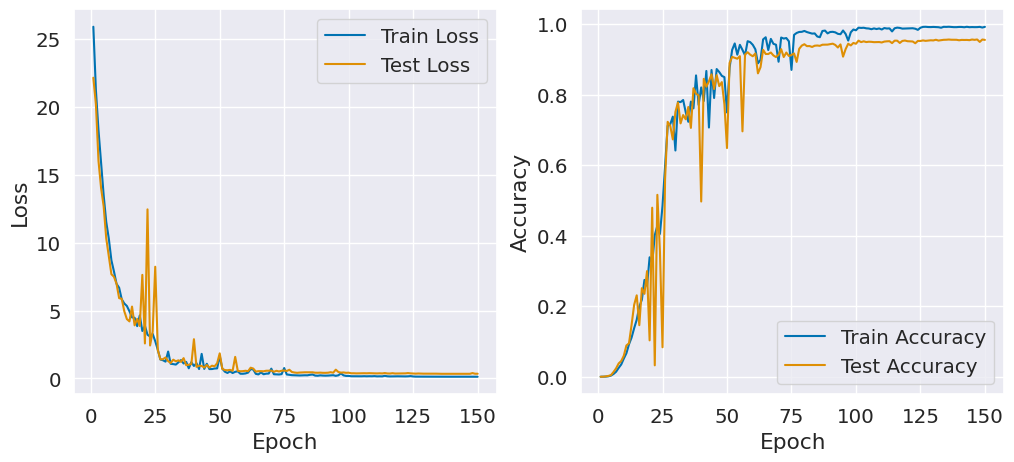

In [857]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))

train_loss = tracker.get_metric("train_loss")
test_loss = tracker.get_metric("test_loss")

train_accuracy = tracker.get_metric("train_accuracy")
test_accuracy = tracker.get_metric("test_accuracy")

ax[0].plot(train_loss[:,0], train_loss[:,1], label='Train Loss')
ax[0].plot(test_loss[:,0], test_loss[:,1], label='Test Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_accuracy[:,0], train_accuracy[:,1], label='Train Accuracy')
ax[1].plot(test_accuracy[:,0], test_accuracy[:,1], label='Test Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# plt.savefig(os.path.join("models", f"vae_latent_{latent_size}.png"))
plt.show()

In [856]:
# torch.save(model.state_dict(), os.path.join("models", f"vae_latent_{latent_size}.pt"))

## Characterization

In [383]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

selfies = list(df.selfies)
selfies_encoder = SelfiesEncoder.build(selfies)

In [436]:
latent_size = 50
model_weights = torch.load(os.path.join("models", f"vae_latent_{latent_size}.pt"))

vae = MolecularVAE(latent_size=latent_size)
vae.load_state_dict(model_weights)

vae.eval()

MolecularVAE(
  (encoder_conv): Sequential(
    (0): Conv1d(29, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(9, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(9, 10, kernel_size=(10,), stride=(1,), padding=(2,))
    (5): ReLU()
  )
  (encoder_linear): Sequential(
    (0): Linear(in_features=80, out_features=400, bias=True)
    (1): SELU()
  )
  (encoder_mean): Linear(in_features=400, out_features=50, bias=True)
  (encoder_logvar): Linear(in_features=400, out_features=50, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): SELU()
  )
  (decoder_gru): GRU(50, 500, num_layers=3, batch_first=True)
  (decoder_output): Linear(in_features=500, out_features=29, bias=True)
)

In [437]:
start_selfie = sf.encoder("C")
end_selfie = sf.encoder("CCCCOCCCCCCCCCO")

start_x = torch.tensor(selfies_encoder.encode_one_hot(start_selfie), dtype=torch.float32)
end_x = torch.tensor(selfies_encoder.encode_one_hot(end_selfie), dtype=torch.float32)

interp_x = vae.interpolate(start_x, end_x, 10)
interp_x = interp_x

interp_selfies = [selfies_encoder.decode_tensor(x) for x in interp_x]
interp_mols = [Chem.MolFromSmiles(sf.decoder(s)) for s in interp_selfies]

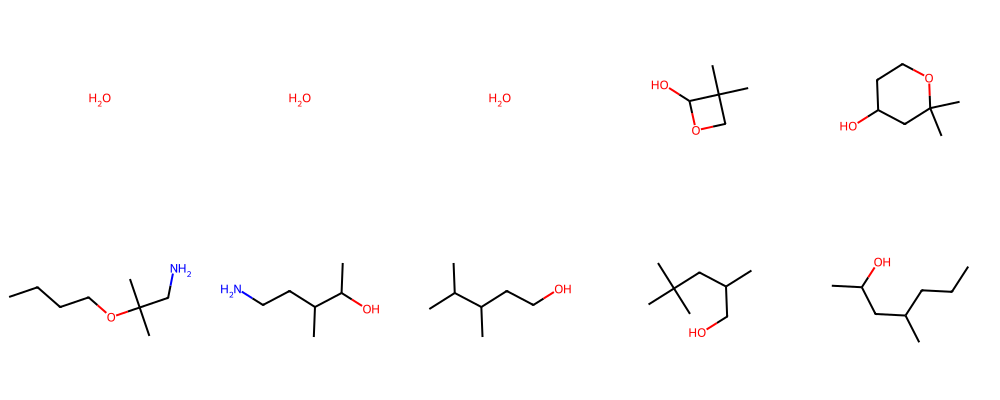

In [438]:
Chem.Draw.MolsToGridImage(interp_mols, molsPerRow=5)

### Regression

In [439]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

from sklearn.metrics import r2_score

torch.manual_seed(145);

In [440]:
x_sample = torch.load(os.path.join("data", "qm9_encodings.pt"))
x_sample = x_sample[torch.randperm(x_sample.shape[0])]
x_sample = x_sample[::25].float()
x_sample.shape

torch.Size([5356, 21, 29])

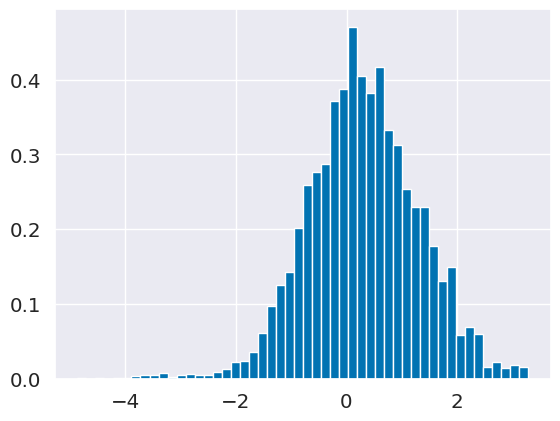

In [441]:
selfies_sample = [selfies_encoder.decode_tensor(xi) for xi in x_sample]
mols_sample = [Chem.MolFromSmiles(sf.decoder(s)) for s in selfies_sample]
y_sample = [Descriptors.MolLogP(m) for m in mols_sample]

plt.hist(y_sample, bins=50, density=True)
plt.show()

In [442]:
y = torch.tensor(y_sample).view(-1, 1).double()

y_scaled = botorch.utils.transforms.standardize(y)

In [443]:
z = vae.encode(x_sample)[0].detach().double()

z_min = z.min(dim=0).values
z_max = z.max(dim=0).values
z_bounds = torch.stack((z_min, z_max))

z_scaled = botorch.utils.transforms.normalize(z, z_bounds)

In [473]:
indices = torch.randperm(z.shape[0])

n_train = 2500

ind_train = indices[:n_train]
ind_test = indices[n_train:]

z_train = z_scaled[ind_train]
z_test = z_scaled[ind_test]

y_train = y_scaled[ind_train]
y_test = y_scaled[ind_test]

In [474]:
gp = SingleTaskGP(z_train, y_train)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

/home/sfriedowitz/miniconda3/envs/ssl/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0230], dtype=torch.float64), std = tensor([0.9990], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [475]:
mll = botorch.fit.fit_gpytorch_mll(mll)

In [476]:
mvn = gp(z_test)

y_pred_mean = mvn.mean.detach()
y_pred_std = mvn.stddev

In [478]:
r2_score(y_test.flatten().numpy(), y_pred_mean.detach().numpy())

0.6098704799262179

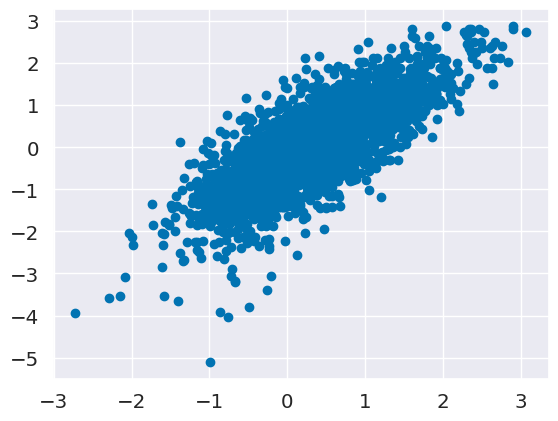

In [481]:
plt.scatter(y.mean() + y_pred_mean * y.std(), y_test.flatten())

plt.show()